# DESU Data Science - Human Design Group project

Context:    
There is a growing interest in virtual reality settings for realistic vidoegames and traning courses (for ex. pilots, maintenance, etc).     
Some people may however experience symptoms as headache, nausea and.. , grouped under the general phenomenon of cybersickness (CS).   
CS should be tackled by understanding which types of tasks/movements may induce it more;    
it is important to find ways to predict cybersickness in real time during tasks and understand whether some types of people are more inclined to experience CS even before the taks starts.
  
We thus aim at:
1) understand which types of biomarkers can better predict or signal the presence of CS;
2) evaluate the importance of each different task type on CS:
3) predict when CS arrives
4) ONLY IF I HAVE TIME: use questionnaires before the task to predict whether some people are more inclined to CS with respect to others


In [91]:
import os
import sys
print(os.getcwd())  # To check current working directory
print(sys.path) 

c:\Users\saras\Desktop\DESU_HDGproject
['c:\\Users\\saras\\Desktop\\DESU_HDGproject', 'c:\\Users\\saras\\miniconda3\\python311.zip', 'c:\\Users\\saras\\miniconda3\\DLLs', 'c:\\Users\\saras\\miniconda3\\Lib', 'c:\\Users\\saras\\miniconda3', '', 'c:\\Users\\saras\\miniconda3\\Lib\\site-packages', 'c:\\Users\\saras\\miniconda3\\Lib\\site-packages\\win32', 'c:\\Users\\saras\\miniconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\saras\\miniconda3\\Lib\\site-packages\\Pythonwin', '../', '../']


In [92]:
# basic
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from sklearn import preprocessing

# models
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# side useful
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# personal functions 
sys.path.append('../')
from Functions_DESU import my_preprocessing


In [176]:
# Upload dataset
filepath = "C:/Users/saras/Desktop/OnedriveAMU/OneDrive - Aix-Marseille Université/PhD/Courses/DESU data science/DESU Sara/Tutored_project_HDG/script_a_passer_DESU/complete_forward_features_LATEST.csv"
raw_df = pd.read_csv(filepath)
raw_df.head()

raw_df.shape

(1259, 73)

1) nettoyage des données (doubles, missing, outliers)
2) pre-processing (encodage donnes categorielles, scaling, equilibrage, discretisation)
3) improve quality of information in database (creation and selection of feautures like ICA)

In [94]:
# Find and impute missing data with homemade function. 
# Drop columns with missing data % > threshold. 
df = my_preprocessing.handle_missing(raw_df, method='ffill', threshold=60)


Percentage of missing data per column:
 low_noise       100.000000
bradygastria     36.536934
normogastria     20.174742
block            19.539317
trial            19.539317
                   ...    
MinDmtPPL         0.000000
MaxDmtPPL         0.000000
DiffDmtPPL        0.000000
AvgDmtPPL         0.000000
sub               0.000000
Length: 73, dtype: float64

Dropped columns with missing data > 60%: ['low_noise']


In [95]:
# Check imputation
percent_missing = df.isnull().sum()*100/len(df)
percent_missing.sort_values(ascending=False, inplace=True)

print(percent_missing.head(5))

change        0.0
win           0.0
SdDmtPPL      0.0
AvgDmtPPL     0.0
DiffDmtPPL    0.0
dtype: float64


In [96]:
# Find inf values and replace them with zeors
df_inf = df.copy()
df_inf.drop(columns=['ses', 'sub'], inplace=True)

nb_infinit_values = np.isinf(df_inf).values.sum()
print(f'There are {nb_infinit_values} infinity values')
col_name = df_inf.columns.to_series()[np.isinf(df_inf).any()]
print(col_name)

df['HRV_SampEn'].replace([np.inf, -np.inf], 0, inplace=True)

There are 16 infinity values
HRV_SampEn    HRV_SampEn
dtype: object


There are no more missing values, so we can proceed with other preprocessing analyses.    
We should now identify the categorical variables and convert them into numerical features.

In [97]:
# Identify categorical features
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['ses', 'sub'], dtype='object')


We dont really care about which subject corresponds to which data, so we can only transform "session".   
We avoid ordering so we can use one hot encoder.

In [98]:
df['ses'].values

array(['ses-01', 'ses-01', 'ses-01', ..., 'ses-03', 'ses-03', 'ses-03'],
      dtype=object)

In [99]:
encoded_data = pd.get_dummies(df, columns=['ses'], drop_first=True)
print(encoded_data.shape) 

df = encoded_data
df.sample(5)

(1259, 73)


,change,win,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_BPM,HRV_si,HRV_lf,HRV_hf,...,SdCntSpdPLT,MinCntSpdPPL,MaxCntSpdPPL,n_blinks,avg_blink_duration,std_blink_duration,blink_frequency,sub,ses_ses-02,ses_ses-03
31,7,1,1071.807229,127.736894,119.384787,22.891566,55.980216,4.456765,4365.495549,6762.223954,...,0.406970,0.165,1.575,27.0,126.666667,37.490740,54.0,sub-01,False,False
77,0,2,1126.392405,151.065086,201.159062,23.417722,53.267405,8.420473,2790.463020,6302.162949,...,0.589751,0.315,2.790,5.0,147.000000,55.641711,10.0,sub-01,True,False
332,7,0,878.128079,114.140973,153.419763,15.270936,68.327163,6.406740,2054.297877,3332.598706,...,0.373810,0.225,1.515,6.0,237.500000,106.213229,12.0,sub-02,True,False
396,25,0,872.975610,164.470107,217.344716,18.536585,68.730443,4.781042,3519.127372,6242.810310,...,0.673062,0.210,2.955,12.0,262.500000,55.283361,24.0,sub-02,True,False
350,11,2,876.323529,176.915869,231.349649,19.607843,68.467864,5.335157,4562.869250,6845.438249,...,0.479861,0.300,2.010,7.0,265.714286,128.213788,14.0,sub-02,True,False


<Axes: >

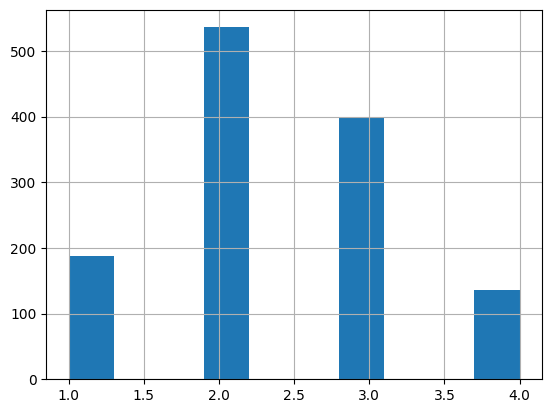

In [100]:
# Now we binarize the cybersickness to have only two values 
# Keep the original too to try multilevel classification
df['DiscomfortLevel'].unique()
df['DiscomfortLevel'].hist()

,DiscomfortLevel,BinaryCS
725,2.0,0
303,1.0,0
1055,2.0,0
584,4.0,1
309,2.0,0


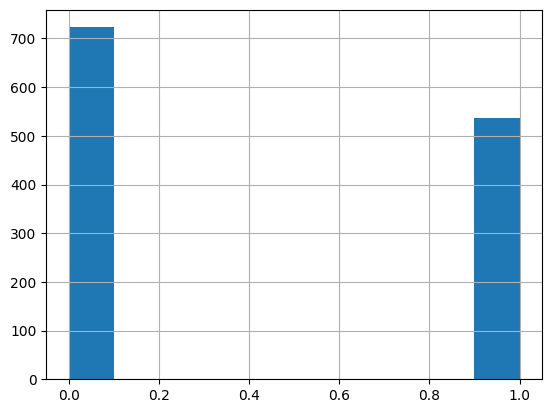

In [101]:
# we have a lot of 2 and 3 scores of CS so we binarize as:
class_1 = df['DiscomfortLevel'] > 2
df['BinaryCS'] = 0
df.loc[class_1, 'BinaryCS'] = 1

df['BinaryCS'].hist()
df[['DiscomfortLevel', 'BinaryCS']].sample(5)


Now we have to separate into a training set and a test set.

In [102]:
# Let's keeep both binary and non binary CS levels
train_data = df.drop(columns=["BinaryCS", "DiscomfortLevel"])

target_nonbin = df['DiscomfortLevel']
target_binary = df['BinaryCS']

X_train, X_test, y_train, y_test = train_test_split(train_data,target_nonbin,test_size=0.25,random_state=42, stratify=target_nonbin) #  stratify is for unbalanced classes
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(train_data,target_binary,test_size=0.25,random_state=42, stratify=target_nonbin) #,random_state=23??

# NB: since random state is fix, X_train_bin == X_train and X_test == X_test_bin !!!!!! Only y changes

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
X_train.head()

(944, 72)
(315, 72)
(944,)


,change,win,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_BPM,HRV_si,HRV_lf,HRV_hf,...,SdCntSpdPLT,MinCntSpdPPL,MaxCntSpdPPL,n_blinks,avg_blink_duration,std_blink_duration,blink_frequency,sub,ses_ses-02,ses_ses-03
523,3,2,626.188811,64.995163,87.587550,2.097902,95.817745,10.384615,747.895638,988.696937,...,0.421553,0.150,1.440,10.0,346.5,359.340020,20.0,sub-04,True,False
352,12,0,884.405941,147.900375,202.018422,17.326733,67.842149,8.278015,2418.969973,6153.646746,...,0.588265,0.240,2.430,5.0,285.0,85.906926,10.0,sub-02,True,False
471,1,1,724.453441,124.389586,174.172842,9.311741,82.821057,11.071994,2255.848217,3495.776724,...,0.274233,0.285,1.260,5.0,156.0,27.820855,10.0,sub-03,True,False
558,14,0,585.140845,69.463352,80.508138,2.112676,102.539415,11.860638,764.372624,1104.590295,...,0.341771,0.210,1.605,12.0,470.0,550.670046,24.0,sub-04,False,True
1235,0,1,653.759124,151.062514,205.487003,29.197080,91.776922,9.352963,1950.845297,6756.856585,...,0.304814,0.165,1.755,3.0,250.0,157.955690,6.0,sub-23,False,False


In [103]:
X_test == X_test_bin

,change,win,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_BPM,HRV_si,HRV_lf,HRV_hf,...,SdCntSpdPLT,MinCntSpdPPL,MaxCntSpdPPL,n_blinks,avg_blink_duration,std_blink_duration,blink_frequency,sub,ses_ses-02,ses_ses-03
259,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
390,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
50,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1119,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
62,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
518,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
884,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
427,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [104]:
# NOT WORKING:
# Fill with average to fill test-df with average values of the train dataset.

# new_train, new_test = my_preprocessing.handle_missing(X_train, method='mean', threshold=60, test_df = X_test, fill_numeric_only=True)

In [105]:
X_train.describe()

,change,win,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_BPM,HRV_si,HRV_lf,HRV_hf,...,MindltSpdPPL,MaxDltSpdPPL,AvgCntSpdPPL,SdCntSpdPLT,MinCntSpdPPL,MaxCntSpdPPL,n_blinks,avg_blink_duration,std_blink_duration,blink_frequency
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,...,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,7.375000,1.082627,824.099520,147.230942,192.101867,17.325070,75.885809,8.661002,3409.700830,6535.359921,...,0.241367,2.302278,0.733753,0.466032,0.236202,1.921112,8.382415,181.497871,67.726131,16.764831
std,7.930454,1.161213,169.547952,72.052005,110.028221,11.569147,15.246848,6.805678,3058.510813,7073.283549,...,0.065397,0.731124,0.139467,0.141567,0.072092,0.531372,5.689840,81.605350,95.453107,11.379681
min,0.000000,0.000000,532.734375,0.000000,0.000000,0.000000,48.389807,0.000000,0.000000,0.000000,...,0.015000,0.630000,0.337857,0.000000,0.045000,0.465000,0.000000,90.000000,0.000000,0.000000
25%,1.000000,0.000000,676.723485,97.572401,113.895153,8.617157,65.119668,4.851387,1468.540703,2210.012301,...,0.210000,1.770000,0.635000,0.366659,0.195000,1.560000,5.000000,127.500000,21.384757,10.000000
50%,5.000000,1.000000,843.679245,151.954891,201.884288,16.386376,71.117083,6.993590,2958.165977,5771.759917,...,0.255000,2.130000,0.724167,0.442648,0.240000,1.815000,8.000000,153.541667,34.871720,16.000000
75%,11.000000,2.000000,921.380748,181.742180,246.441370,23.513932,88.662506,10.970150,4352.559704,7821.219705,...,0.270000,2.730000,0.817625,0.541909,0.270000,2.220000,11.000000,222.125000,73.076564,22.000000
max,41.000000,4.000000,1239.930556,575.579838,761.756344,75.000000,112.626485,75.232367,29178.745291,79084.785388,...,0.600000,6.375000,1.268182,1.258122,0.870000,4.635000,39.000000,973.500000,893.210641,78.000000


## Feature importance

In [106]:
#We can first do it for the first subject only:
train_all = pd.concat([X_train, y_train], axis=1)
train_all.head()
# subone = df['sub'] == 'sub-01'
# sesone = df['ses'] == 'ses-01'
# tmp = df[subone]
# tmp = tmp[sesone]

train_all.drop(columns='sub', inplace= True)

print(train_all.shape)

(944, 72)


### correlation with target variable

In [107]:
# # Compute the Spearman correlation matrix
# corr = train_all.corr(method='spearman')

# # Filter columns that have a correlation higher than 0.3 or lower than -0.3 with "DiscomfortChange"
# corr_filtered = corr[abs(corr['DiscomfortChange']) > 0.1]

# # Extract the rows and columns corresponding to the filtered columns
# corr_filtered = corr_filtered.loc[corr_filtered.index, :]

# corr_filtered



In [108]:
train_all.keys()

Index(['change', 'win', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN50',
       'HRV_BPM', 'HRV_si', 'HRV_lf', 'HRV_hf', 'HRV_lf_hf_ratio',
       'HRV_total_power', 'HRV_SampEn', 'maxEDA', 'rangeEDA', 'avgEDA',
       'sdEDA', 'IqrEDA', 'rmsEDA', 'avgDiff1EDA', 'avgDiff2EDA', 'SkwEDA',
       'KrtEDA', 'vlfEDA', 'lfEDA', 'mfEDA', 'hfEDA', 'vhfEDA', 'NbPeaksSCR',
       'AvgAmpSCR', 'sdAmpSCR', 'MinAmpSCR', 'MaxAmpSCR', 'AvgHRT', 'sdHRT',
       'minHRT', 'maxHRT', 'aSCR_signed', 'aSCR_abs', 'bradygastria',
       'normogastria', 'tachygastria', 'high_noise', 'total_power',
       'DiscomfortChange', 'trial', 'block', 'MinDmtPPL', 'MaxDmtPPL',
       'DiffDmtPPL', 'AvgDmtPPL', 'SdDmtPPL', 'NbCntPPL', 'AvgDltAmpPPL',
       'SdDltAmpPPL', 'MinDltAmpPPL', 'MaxDltAmpPPL', 'AvgDltSpdPPL',
       'SdDltSpdPPL', 'MindltSpdPPL', 'MaxDltSpdPPL', 'AvgCntSpdPPL',
       'SdCntSpdPLT', 'MinCntSpdPPL', 'MaxCntSpdPPL', 'n_blinks',
       'avg_blink_duration', 'std_blink_duration', 'blink_frequen

In [109]:
# drop redundant columns
X_train.drop(columns=['change', 'DiscomfortChange'], inplace = True)
X_test.drop(columns=['change', 'DiscomfortChange'], inplace = True)


In [110]:
X_train.select_dtypes(include=['number'])

,win,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_BPM,HRV_si,HRV_lf,HRV_hf,HRV_lf_hf_ratio,...,MindltSpdPPL,MaxDltSpdPPL,AvgCntSpdPPL,SdCntSpdPLT,MinCntSpdPPL,MaxCntSpdPPL,n_blinks,avg_blink_duration,std_blink_duration,blink_frequency
523,2,626.188811,64.995163,87.587550,2.097902,95.817745,10.384615,747.895638,988.696937,0.756446,...,0.015,1.245,0.631364,0.421553,0.150,1.440,10.0,346.500000,359.340020,20.0
352,0,884.405941,147.900375,202.018422,17.326733,67.842149,8.278015,2418.969973,6153.646746,0.393095,...,0.255,2.625,0.737812,0.588265,0.240,2.430,5.0,285.000000,85.906926,10.0
471,1,724.453441,124.389586,174.172842,9.311741,82.821057,11.071994,2255.848217,3495.776724,0.645307,...,0.195,2.295,0.612632,0.274233,0.285,1.260,5.0,156.000000,27.820855,10.0
558,0,585.140845,69.463352,80.508138,2.112676,102.539415,11.860638,764.372624,1104.590295,0.691997,...,0.180,2.865,0.600000,0.341771,0.210,1.605,12.0,470.000000,550.670046,24.0
1235,1,653.759124,151.062514,205.487003,29.197080,91.776922,9.352963,1950.845297,6756.856585,0.288721,...,0.195,1.740,0.432778,0.304814,0.165,1.755,3.0,250.000000,157.955690,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0,932.291667,176.626201,242.396413,20.833333,64.357542,5.253233,3889.040249,7746.317416,0.502050,...,0.270,3.450,0.747000,0.412512,0.315,1.695,7.0,111.428571,13.552619,14.0
201,2,869.320388,95.695270,110.548522,16.504854,69.019433,6.731950,1470.244637,1740.632602,0.844661,...,0.270,2.955,0.783750,0.528280,0.360,2.325,6.0,260.000000,141.950696,12.0
12,2,1084.060606,90.956281,90.802654,21.212121,55.347459,3.668544,1610.759033,2205.602939,0.730303,...,0.270,1.590,0.712895,0.393397,0.315,1.680,10.0,135.000000,33.541020,20.0
1140,2,635.757576,155.136587,212.915064,9.848485,94.375596,14.791988,3582.589651,5218.779295,0.686480,...,0.165,1.380,0.737143,0.643466,0.195,2.700,10.0,193.500000,64.150214,20.0


In [111]:
# Scale features (with RobustScaler)

# Fit and transform train dataset, then apply the transform on the test dataset without refitting
X_train_scaled, X_test_scaled = my_preprocessing.scale_data(X_train.select_dtypes(include=['number']), X_test.select_dtypes(include=['number']))
# USELESS CAUSE SAME AS ABPVE: X_train_binscaled, X_test_binscaled = my_preprocessing.scale_data(X_train_bin.select_dtypes(include=['number']), X_test_bin.select_dtypes(include=['number']))

In [112]:
X_train_scaled.head(10)

,win,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_BPM,HRV_si,HRV_lf,HRV_hf,HRV_lf_hf_ratio,...,MindltSpdPPL,MaxDltSpdPPL,AvgCntSpdPPL,SdCntSpdPLT,MinCntSpdPPL,MaxCntSpdPPL,n_blinks,avg_blink_duration,std_blink_duration,blink_frequency
523,0.5,-0.888960,-1.033147,-0.862316,-0.959166,1.049179,0.554201,-0.766385,-0.852412,0.621813,...,-4.00,-0.921875,-0.508162,-0.120370,-1.2,-0.568182,0.333333,2.039190,6.276977,0.333333
352,-0.5,0.166464,-0.048171,0.001012,0.063125,-0.139105,0.209916,-0.186960,0.068058,-0.642689,...,0.00,0.515625,0.074721,0.830914,0.0,0.931818,-0.500000,1.389256,0.987298,-0.500000
471,0.0,-0.487318,-0.327496,-0.209070,-0.474911,0.497135,0.666541,-0.243521,-0.405614,0.235036,...,-1.00,0.171875,-0.610733,-0.961003,0.6,-0.840909,-0.500000,0.025980,-0.136402,-0.500000
558,-0.5,-1.056737,-0.980061,-0.915727,-0.958174,1.334687,0.795430,-0.760672,-0.831759,0.397522,...,-1.25,0.765625,-0.679900,-0.575622,-0.4,-0.318182,0.666667,3.344342,9.978338,0.666667
1235,0.0,-0.776270,-0.010602,0.027181,0.859965,0.877542,0.385596,-0.349277,0.175559,-1.005925,...,-1.00,-0.406250,-1.595559,-0.786501,-1.0,-0.090909,-0.833333,1.019375,2.381112,-0.833333
298,-0.5,0.239079,0.531829,0.535299,0.391752,-0.195851,-0.140688,0.449438,0.759213,-0.534844,...,-1.00,-0.234375,-0.552590,-0.397429,0.2,-0.340909,0.500000,0.639886,0.599855,0.500000
1256,0.0,-0.254642,-1.449306,-1.315526,-0.868517,0.240846,-0.889373,-0.956618,-1.010601,4.850678,...,0.00,-0.046875,2.517068,2.198601,0.4,1.931818,-1.000000,0.675914,0.631208,-1.000000
893,-0.5,-0.818884,0.271478,0.281897,1.739137,0.940718,0.222183,0.564974,0.124639,0.456443,...,0.25,-0.156250,-0.563944,-0.313224,-0.8,0.045455,-0.833333,-0.301629,-0.127437,-0.833333
1212,-0.5,1.486787,0.463868,0.391546,1.893579,-0.910037,0.080772,0.586334,0.600092,-0.240312,...,-0.50,1.296875,-0.046973,0.125636,-1.4,-0.113636,-0.833333,3.080141,3.847837,-0.833333
54,-0.5,0.930926,-0.291295,-0.620871,0.507876,-0.642129,-0.418959,0.479166,0.181939,0.212874,...,-0.75,-1.015625,-0.664966,-0.694856,0.2,-0.295455,1.000000,-0.433730,-0.315004,1.000000


### Embedded Feature Selection approach

Now, we should understand which features we can exclude.
First of all, we can calculate the correlation between all features:

<Axes: >

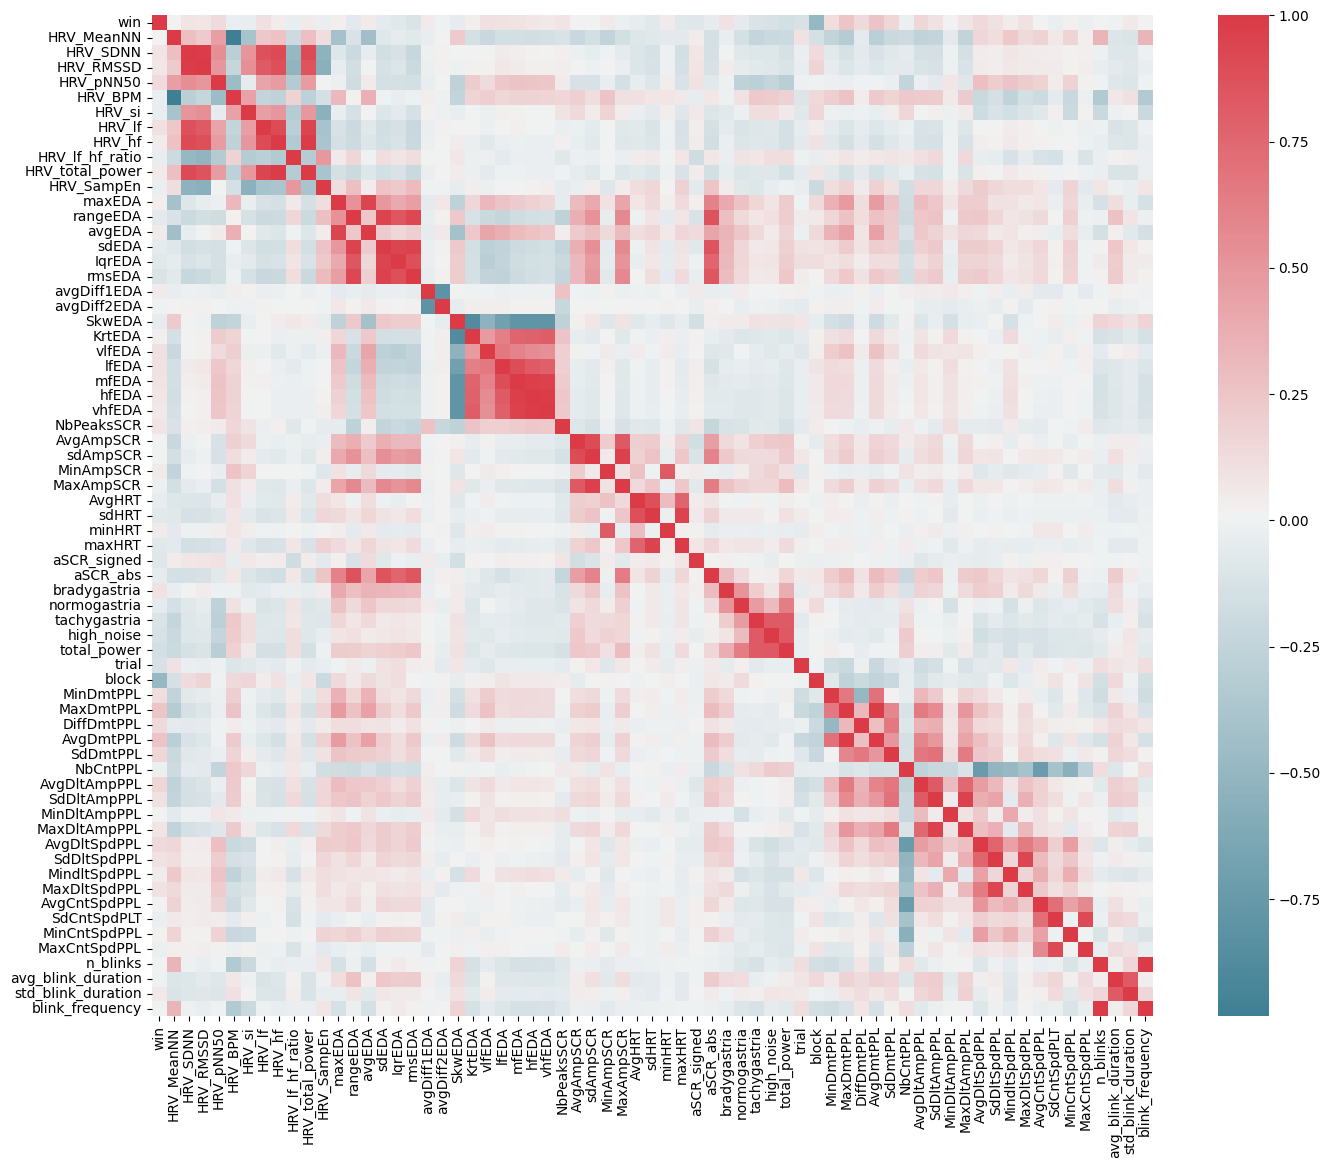

In [169]:
f, ax = plt.subplots(figsize=(17, 13))

corr = X_train_scaled.corr()

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [114]:
# Drop columns with strong correlations
threshold = 0.5

# Create a mask to ignore the upper triangle (to avoid duplicate checks)
corr_abs = corr.abs()
upper_tri = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

# Initialize a set to keep track of columns to drop
to_drop = set()

# Iterate over the columns of the upper triangle matrix
for i in range(len(upper_tri.columns)):
    for j in range(i + 1, len(upper_tri.columns)):
        if upper_tri.iloc[i, j] > threshold:
            # Add the column with the higher index to the set
            colname = upper_tri.columns[j]
            if colname not in to_drop:
                to_drop.add(colname)

# Drop the columns
train_selection = X_train_scaled.drop(to_drop, axis=1)
test_selection = X_test_scaled.drop(to_drop, axis=1)

<Axes: >

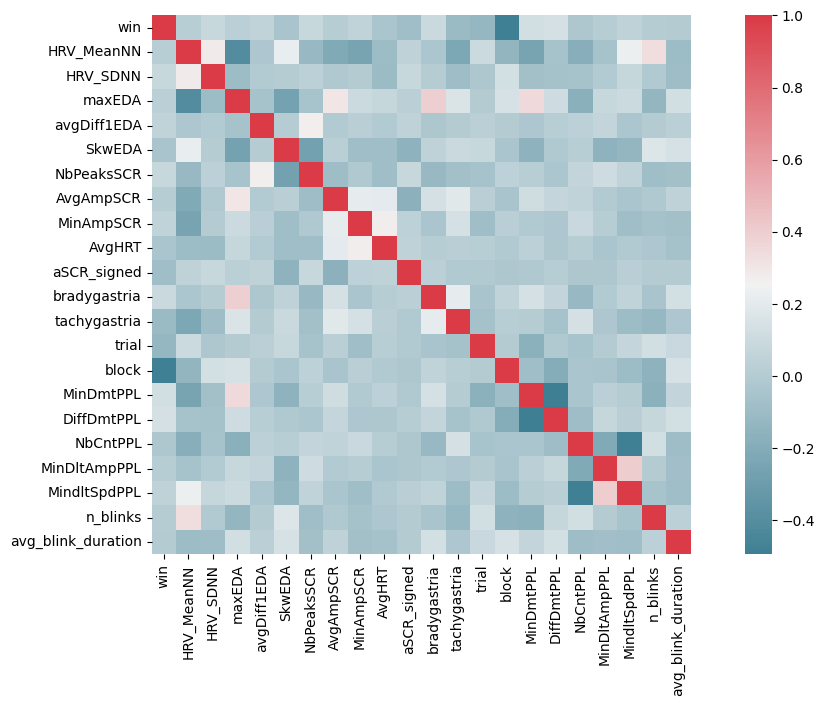

In [115]:
new_corr = train_selection.corr()

f, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(new_corr, mask=np.zeros_like(new_corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


 Now we need to see which features are most important. We can do so by using for instance the Mean Decrease Impurity (random forest)

In [116]:
forest_nocorr = RandomForestClassifier(n_estimators=100, random_state=0)
forest_allvars = RandomForestClassifier(n_estimators=100, random_state=0)

model_nocorr = forest_nocorr.fit(train_selection, y_train)
model_allvars = forest_allvars.fit(X_train_scaled, y_train)

model_nocorr.feature_names_in_

array(['win', 'HRV_MeanNN', 'HRV_SDNN', 'maxEDA', 'avgDiff1EDA', 'SkwEDA',
       'NbPeaksSCR', 'AvgAmpSCR', 'MinAmpSCR', 'AvgHRT', 'aSCR_signed',
       'bradygastria', 'tachygastria', 'trial', 'block', 'MinDmtPPL',
       'DiffDmtPPL', 'NbCntPPL', 'MinDltAmpPPL', 'MindltSpdPPL',
       'n_blinks', 'avg_blink_duration'], dtype=object)

<Axes: >

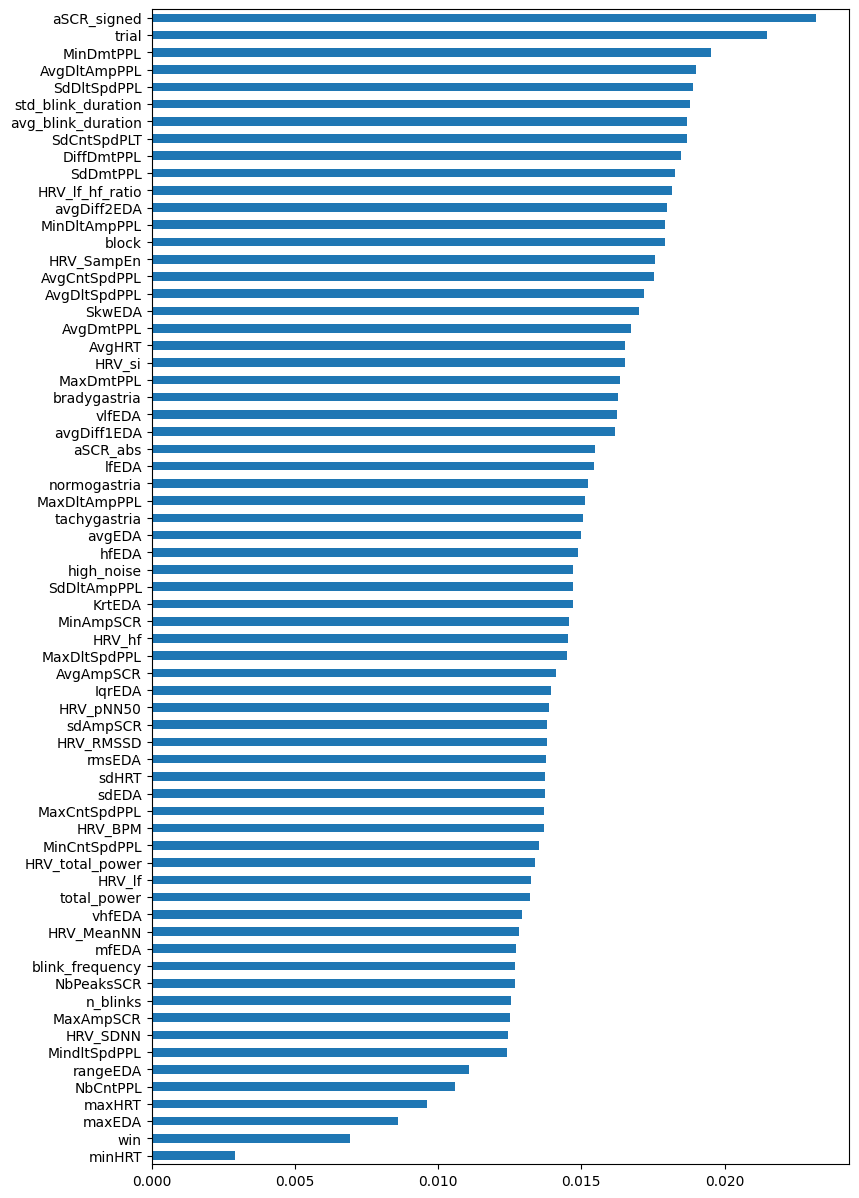

In [171]:
MDI_nocorr = pd.Series(model_nocorr.feature_importances_, index=train_selection.columns)
MDI_allvars = pd.Series(model_allvars.feature_importances_, index=X_train_scaled.columns)

# f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 9))

# MDI_nocorr.sort_values().plot.barh(ax=ax1)
# MDI_allvars.sort_values().plot.barh(ax=ax2)
# # plt.grid()


f, ax = plt.subplots(figsize=(9, 15))
MDI_allvars.sort_values().plot.barh(ax=ax)

# Feature selection: 
- Recursive features elimination (longer cause calculates score testing combinations of features) --> number of features
- SelectFromModel


In [118]:
from sklearn.feature_selection import SelectFromModel
modelsel_allvars = SelectFromModel(forest_allvars, prefit=True)
X_new = modelsel_allvars.transform(X_train_scaled)
features_selected = X_train_scaled.columns[modelsel_allvars.get_support()]

print(features_selected)

X_train_cut = X_train_scaled[features_selected.intersection(X_train_scaled.columns)]
X_test_cut = X_test_scaled[features_selected.intersection(X_test_scaled.columns)]

X_train_cut.head(5)

Index(['HRV_si', 'HRV_lf_hf_ratio', 'HRV_SampEn', 'avgEDA', 'avgDiff1EDA',
       'avgDiff2EDA', 'SkwEDA', 'vlfEDA', 'lfEDA', 'AvgHRT', 'aSCR_signed',
       'aSCR_abs', 'bradygastria', 'normogastria', 'tachygastria', 'trial',
       'block', 'MinDmtPPL', 'MaxDmtPPL', 'DiffDmtPPL', 'AvgDmtPPL',
       'SdDmtPPL', 'AvgDltAmpPPL', 'MinDltAmpPPL', 'MaxDltAmpPPL',
       'AvgDltSpdPPL', 'SdDltSpdPPL', 'AvgCntSpdPPL', 'SdCntSpdPLT',
       'avg_blink_duration', 'std_blink_duration'],
      dtype='object')


c:\Users\saras\miniconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,HRV_si,HRV_lf_hf_ratio,HRV_SampEn,avgEDA,avgDiff1EDA,avgDiff2EDA,SkwEDA,vlfEDA,lfEDA,AvgHRT,...,SdDmtPPL,AvgDltAmpPPL,MinDltAmpPPL,MaxDltAmpPPL,AvgDltSpdPPL,SdDltSpdPPL,AvgCntSpdPPL,SdCntSpdPLT,avg_blink_duration,std_blink_duration
523,0.554201,0.621813,-0.476483,-0.671626,0.658459,-0.366159,1.464586,1.924304,1.200335,-0.230173,...,1.752890,1.832028,0.629658,3.452408,-0.794667,-0.659574,-0.508162,-0.120370,2.039190,6.276977
352,0.209916,-0.642689,0.320320,-0.156555,0.095918,-0.309220,-0.016566,0.008791,-0.047463,-0.568708,...,0.632044,-0.024323,0.697908,0.021468,0.405114,0.369695,0.074721,0.830914,1.389256,0.987298
471,0.666541,0.235036,-0.198344,0.250113,-0.923093,1.053481,-0.012103,0.268946,-0.042561,-0.223153,...,0.113258,-0.371244,-0.087288,0.072410,0.061455,0.480633,-0.610733,-0.961003,0.025980,-0.136402
558,0.795430,0.397522,-0.650581,-0.737700,0.204899,-0.244119,-0.005064,-0.265220,-0.264436,1.510486,...,-0.625556,-0.318770,-0.422913,0.035904,-0.406412,0.281398,-0.679900,-0.575622,3.344342,9.978338
1235,0.385596,-1.005925,-0.043660,-0.208474,-0.708362,-0.286680,-0.450662,0.301560,0.249564,0.098422,...,-0.107885,-0.410365,0.142933,-0.253435,-0.935094,-0.601407,-1.595559,-0.786501,1.019375,2.381112


In [119]:
# Drop columns with strong correlations
threshold = 0.3

new_corr = X_train_cut.corr()

# Create a mask to ignore the upper triangle (to avoid duplicate checks)
newcorr_abs = new_corr.abs()
upper_tri = newcorr_abs.where(np.triu(np.ones(newcorr_abs.shape), k=1).astype(bool))

# Initialize a set to keep track of columns to drop
to_drop = set()

# Iterate over the columns of the upper triangle matrix
for i in range(len(upper_tri.columns)):
    for j in range(i + 1, len(upper_tri.columns)):
        if upper_tri.iloc[i, j] > threshold:
            # Add the column with the higher index to the set
            colname = upper_tri.columns[j]
            if colname not in to_drop:
                to_drop.add(colname)

# Drop the columns
X_train_cut_nocorr = X_train_cut.drop(to_drop, axis=1)
X_test_cut_nocorr = X_test_cut.drop(to_drop, axis=1)

<Axes: >

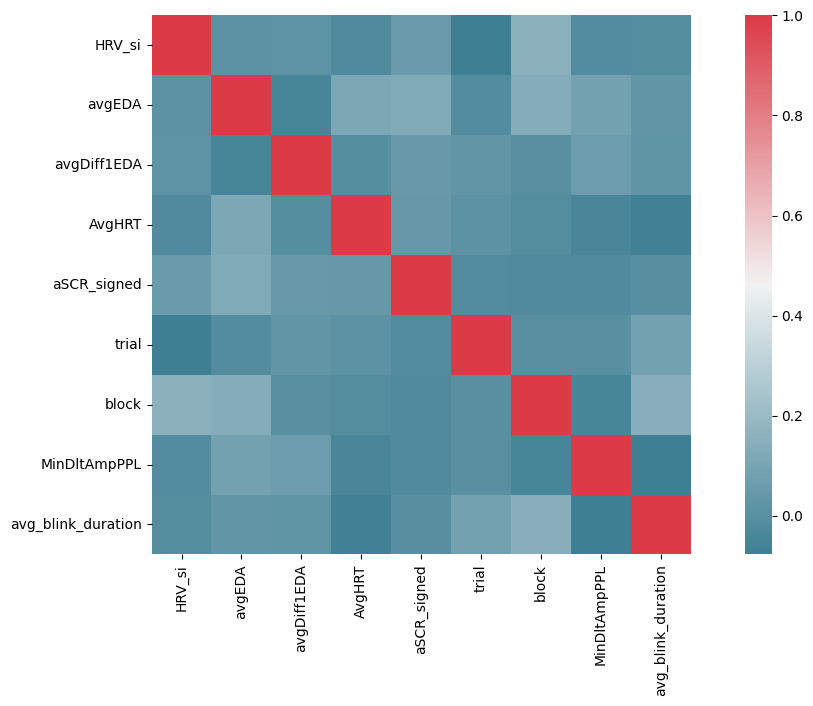

In [120]:
new_corr = X_train_cut_nocorr.corr()

f, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(new_corr, mask=np.zeros_like(new_corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [121]:
train_choice = X_train_cut_nocorr
test_choice = X_test_cut_nocorr

In [122]:
forest_2 = RandomForestClassifier(200, class_weight='balanced')
forest_2.fit(train_choice, y_train)
# prediction

y_pred = forest_2.predict(test_choice)

cm = confusion_matrix(y_test, y_pred)
acc = balanced_accuracy_score(y_test, y_pred)

print(cm)
print(acc)

[[ 2 40  5  0]
 [11 76 45  2]
 [ 0 51 40  9]
 [ 0  8 24  2]]
0.267135225001401


Too small accuracy for non binary categories.

Evaluation Metrics   

- Accuracy: The proportion of correct predictions over the total number of predictions. Best used when the classes are balanced.
- Precision: The proportion of correctly predicted positive observations to the total predicted positives. Useful when the cost of false positives is high.
- Recall (Sensitivity): The proportion of correctly predicted positive observations to all actual positives. Useful when the cost of false negatives is high.
- F1-Score: The harmonic mean of precision and recall, useful when there is class imbalance.
- AUC-ROC (Area Under the Curve - Receiver Operating Characteristic): Measures the ability of the model to distinguish between classes. Useful for binary classification with imbalanced datasets.
- Confusion Matrix: Provides insight into how the model performs with respect to different types of errors (false positives, false negatives).

In [123]:
mapping = {0: 'noCS', 1: 'CS'}

# Apply the mapping to y_train_bin
y_train_bin[:] = np.vectorize(mapping.get)(y_train_bin)
y_test_bin[:] = np.vectorize(mapping.get)(y_test_bin)
y_train_bin


523       CS
352     noCS
471       CS
558       CS
1235    noCS
        ... 
1035      CS
201     noCS
12      noCS
1140      CS
968     noCS
Name: BinaryCS, Length: 944, dtype: object

In [124]:
# Create a basic function to evaluate models
def evaluate_model(model):
    model.fit(train_choice, y_train_bin)
    y_pred_train = model.predict(train_choice)
    y_pred = model.predict(test_choice)
    cm = confusion_matrix(y_test_bin, y_pred)   # , normalize='all'
    dispcm = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

    print(f"Balanced accuracy on test: {balanced_accuracy_score(y_test_bin, y_pred)}")
    print(f"Balanced accuracy on train: {balanced_accuracy_score(y_train_bin, y_pred_train)}")
    print(f"Classification Report:\n{classification_report(y_test_bin, y_pred)}")
    # print(f"AUC-ROC Score: {roc_auc_score(y_test_bin, model.predict_proba(test_choice)[:, 1])}")
    print(f"Confusion matrix:")
    dispcm.plot()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression model: LogisticRegression(C=0.1, class_weight='balanced', random_state=42)
Balanced accuracy on test: 0.5873051867733157
Balanced accuracy on train: 0.6411622698316535
Classification Report:
              precision    recall  f1-score   support

          CS       0.52      0.54      0.53       134
        noCS       0.65      0.63      0.64       181

    accuracy                           0.59       315
   macro avg       0.59      0.59      0.59       315
weighted avg       0.60      0.59      0.59       315

Confusion matrix:


c:\Users\saras\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\saras\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\saras\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\saras\miniconda3\Lib\site-packages\sklearn\linear_model

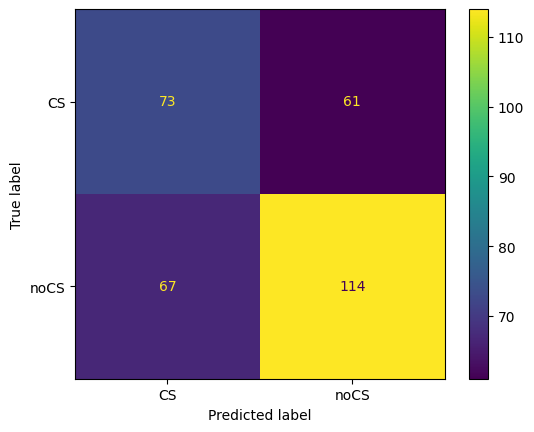

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid_logreg = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.01, 0.1, 1, 10]  # Inverse of regularization strength
}
grid_search_logreg = GridSearchCV(estimator=log_reg, param_grid=param_grid_logreg, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_logreg.fit(train_choice, y_train_bin)
best_log_reg = grid_search_logreg.best_estimator_

print("Best Logistic Regression model:", grid_search_logreg.best_estimator_)
evaluate_model(best_log_reg)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM model: SVC(C=10, class_weight='balanced', random_state=42)
Balanced accuracy on test: 0.573348725983343
Balanced accuracy on train: 0.6815966293991298
Classification Report:
              precision    recall  f1-score   support

          CS       0.51      0.52      0.51       134
        noCS       0.64      0.62      0.63       181

    accuracy                           0.58       315
   macro avg       0.57      0.57      0.57       315
weighted avg       0.58      0.58      0.58       315

Confusion matrix:


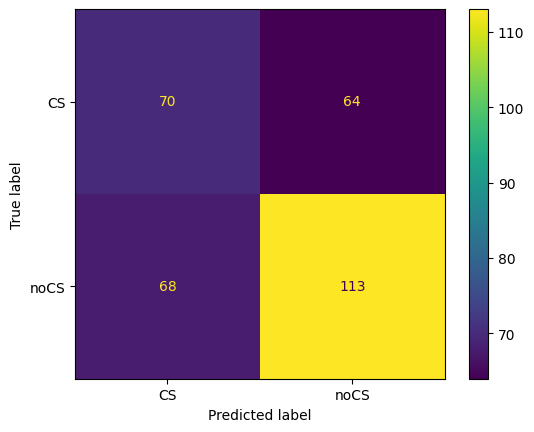

In [173]:
from sklearn.svm import SVC

# Support Vector Machine model
svm_model = SVC(class_weight='balanced', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient
}
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_svm.fit(train_choice, y_train_bin)
best_svm = grid_search_svm.best_estimator_

print("Best SVM model:", grid_search_svm.best_estimator_)
evaluate_model(best_svm)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42)
Balanced accuracy on test: 0.6405129050878205
Balanced accuracy on train: 0.9258275045437021
Classification Report:
              precision    recall  f1-score   support

          CS       0.56      0.66      0.61       134
        noCS       0.71      0.62      0.66       181

    accuracy                           0.64       315
   macro avg       0.64      0.64      0.64       315
weighted avg       0.65      0.64      0.64       315

Confusion matrix:


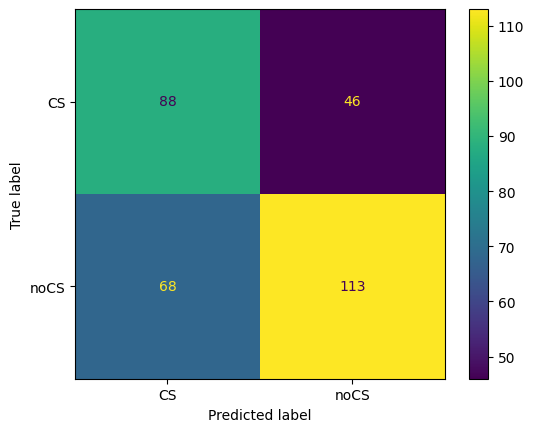

In [174]:
# RandomForest Classifier (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
# evaluate_model(rf_model)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),  param_grid=param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
grid_search.fit(train_choice, y_train_bin)
best_rf = grid_search.best_estimator_
print(grid_search.best_estimator_)
evaluate_model(best_rf)


Balanced accuracy on test: 0.6585923971303702
Balanced accuracy on train: 1.0
Classification Report:
              precision    recall  f1-score   support

          CS       0.61      0.60      0.61       134
        noCS       0.71      0.71      0.71       181

    accuracy                           0.67       315
   macro avg       0.66      0.66      0.66       315
weighted avg       0.67      0.67      0.67       315

Confusion matrix:


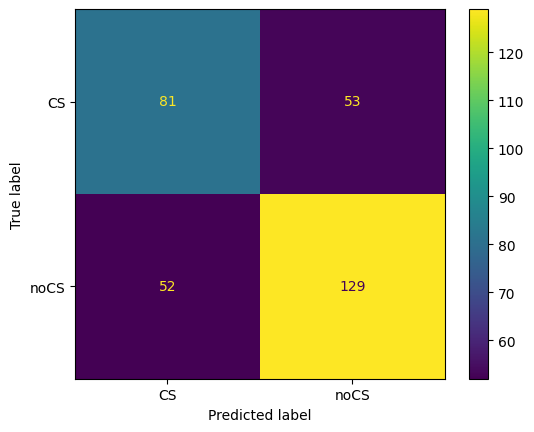

In [126]:
# Bagging Classifier with DecisionTree as base estimator
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight="balanced"), n_estimators=200, random_state=42)
evaluate_model(bagging_model)

Models show high accuracy on the training set but low accuracy on the test set --> overfitting.    
Solutions: 

1. Reduce the Complexity of the Base Estimator (Decision Tree)

Balanced accuracy on test: 0.669683351199802
Balanced accuracy on train: 0.8239476051476933
Classification Report:
              precision    recall  f1-score   support

          CS       0.57      0.75      0.65       134
        noCS       0.76      0.59      0.66       181

    accuracy                           0.66       315
   macro avg       0.67      0.67      0.66       315
weighted avg       0.68      0.66      0.66       315

Confusion matrix:


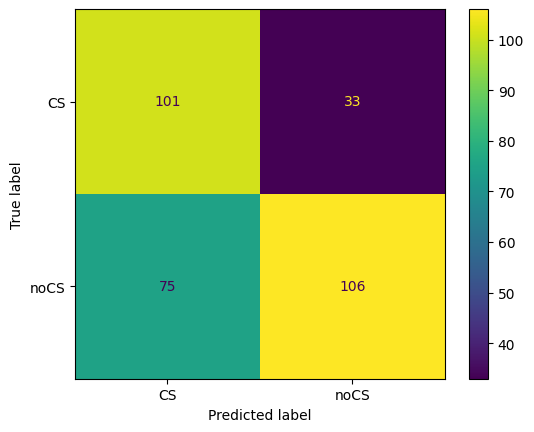

In [149]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Reduce the complexity of the base estimator (Decision Tree)
base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_split=10, class_weight="balanced")

# Rebuild the bagging classifier with the tuned DecisionTreeClassifier
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=200, random_state=42)

# Evaluate the model
evaluate_model(bagging_model)

2. Tune Bagging Hyperparameters   

Adjust the bagging model's hyperparameters to control how the base estimators are trained and combined.

Balanced accuracy on test: 0.6714356394821472
Balanced accuracy on train: 1.0
Classification Report:
              precision    recall  f1-score   support

          CS       0.63      0.60      0.62       134
        noCS       0.71      0.75      0.73       181

    accuracy                           0.68       315
   macro avg       0.67      0.67      0.67       315
weighted avg       0.68      0.68      0.68       315

Confusion matrix:


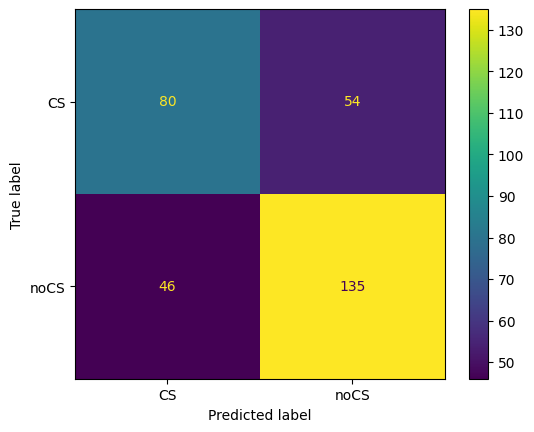

In [142]:
bagging_model = BaggingClassifier(base_estimator=base_estimator, 
                                  n_estimators=100, 
                                  max_samples=0.8,   # Train each base estimator on 80% of the samples-->adds randomness and can improve generalization
                                  max_features=0.8,  # Use only 80% of the features--> diversity in the base estimators, reducing overfitting
                                  random_state=42)
evaluate_model(bagging_model)

3. Use Cross-Validation

Cross-validation helps ensure that your model generalizes well to unseen data.   
By evaluating your model's performance on different subsets of the data, you can get a better sense of its ability to avoid overfitting.

4. Increase the Number of Estimators

Increasing the number of base estimators (n_estimators) in the bagging classifier can improve its generalization ability.   
More estimators increase the stability of the predictions by reducing variance.

Balanced accuracy on test: 0.6781149501113218
Balanced accuracy on train: 0.7874006352003818
Classification Report:
              precision    recall  f1-score   support

          CS       0.58      0.78      0.66       134
        noCS       0.78      0.58      0.66       181

    accuracy                           0.66       315
   macro avg       0.68      0.68      0.66       315
weighted avg       0.69      0.66      0.66       315

Confusion matrix:


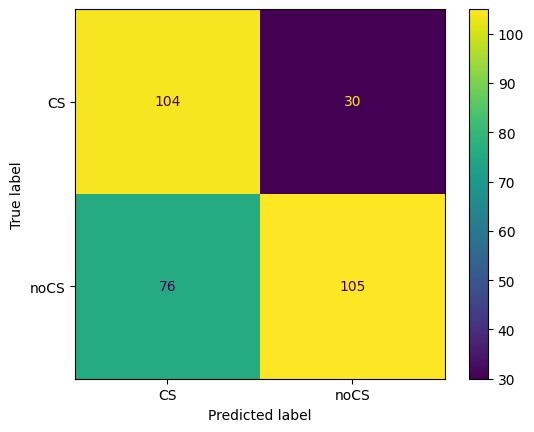

In [130]:
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=500, random_state=42)
evaluate_model(bagging_model)


In [155]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Define the base estimator
base_estimator = DecisionTreeClassifier(class_weight="balanced")

# Define the BaggingClassifier
bagging_model = BaggingClassifier(base_estimator=base_estimator, random_state=42)

# Define the parameter grid for GridSearch
param_grid = {
    'base_estimator__max_depth': [3, 5, 7],               # Different max depths for the decision tree
    'base_estimator__min_samples_split': [2, 5, 10],      # Different min samples split for the decision tree
    'base_estimator__ccp_alpha': [0.0, 0.01, 0.1],        # Different values for pruning parameter
    'n_estimators': [50, 100, 200, 500]                        # Number of base estimators in the ensemble
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

# Fit the model to find the best parameters
grid_search.fit(train_choice, y_train_bin)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        max_depth=3),
                  n_estimators=100, random_state=42)
Balanced accuracy on test: 0.6597468458810918
Balanced accuracy on train: 0.713549411613519
Classification Report:
              precision    recall  f1-score   support

          CS       0.56      0.78      0.65       134
        noCS       0.77      0.54      0.63       181

    accuracy                           0.64       315
   macro avg       0.66      0.66      0.64       315
weighted avg       0.68      0.64      0.64       315

Confusion matrix:


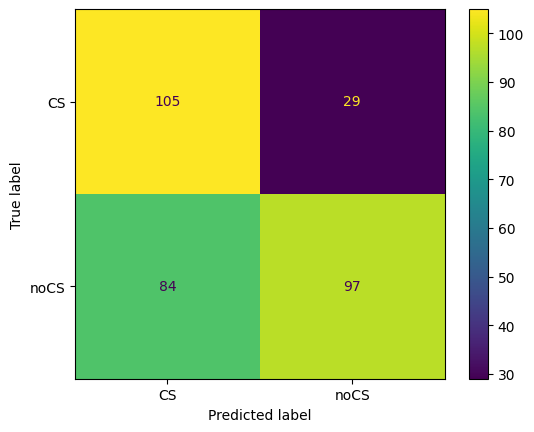

In [156]:
print(grid_search.best_estimator_)
# Evaluate the best model
evaluate_model(best_model)


# cross-validate the best model using cross_val_score
cv_scores = cross_val_score(best_model, train_choice, y_train_bin, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy scores: {cv_scores}")
print(f"Mean cross-validated accuracy: {cv_scores.mean()}")

y_score_bagging = best_model.predict_proba(test_choice)[:,1]


Summary of solutions:

- Simplify the base estimator: Limit the depth, leaf size, and split size of the decision tree.
- Tune bagging hyperparameters: Adjust max_samples, max_features, and n_estimators.
- Use cross-validation to better assess model performance.
- Increase the number of base estimators for more stable predictions.
- Add regularization such as pruning with ccp_alpha.
- Feature selection to reduce noise from irrelevant features.
- Switch to more diverse ensemble models like Random Forest or Boosting.
- Consider regularized models if switching algorithms.

In [129]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(bagging_model, train_choice, y_train_bin, cv=5, scoring='accuracy')
print(f'Cross-Validation acc: {np.mean(scores):.4f} ± {np.std(scores):.4f}')


Cross-Validation acc: 0.6865 ± 0.0303


## ROC curves

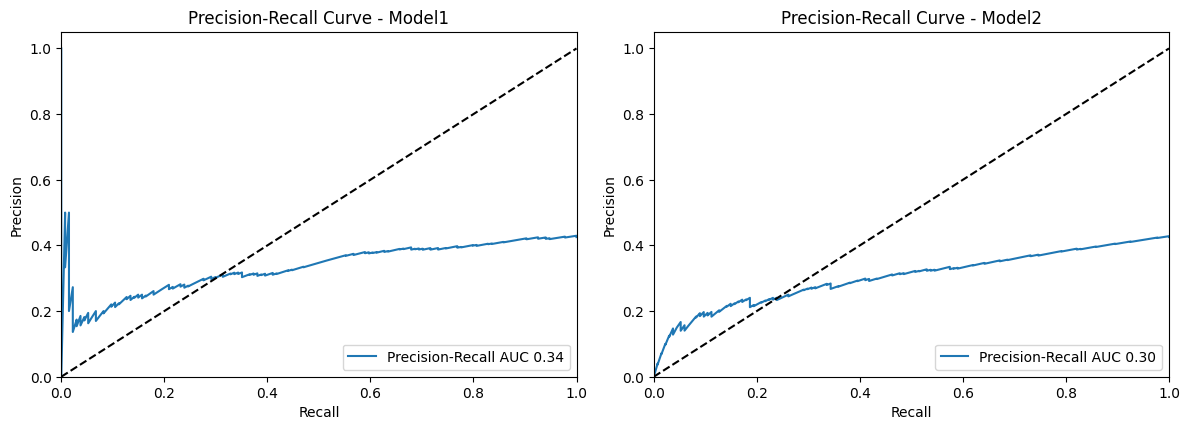

In [154]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

models = {'Model1': y_score_logreg, 'Model2': y_score_bagging}
model_names = ['Model1', 'Model2']

# Create a figure for subplots
plt.figure(figsize=(12, 8))

for i, model_name in enumerate(model_names, 1):
    y_score = models[model_name]
    
    # Compute ROC curve
    precision, recall, thr = precision_recall_curve(y_test_bin, y_score, pos_label='CS')
    pr_auc = auc(recall, precision)
    
    plt.subplot(2, 2, i)
    plt.plot(recall, precision, label=f'Precision-Recall AUC {pr_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('PrecRecall_curves.png')
plt.show()

From which CS level do we start seing a change in parameters???? like an anomaly detector  --> LSTM, non supervisé

## Test without feature selection

In [143]:
train_choice = train_selection
test_choice = test_selection

Balanced accuracy on test: 0.669683351199802
Balanced accuracy on train: 0.8239476051476933
Classification Report:
              precision    recall  f1-score   support

          CS       0.57      0.75      0.65       134
        noCS       0.76      0.59      0.66       181

    accuracy                           0.66       315
   macro avg       0.67      0.67      0.66       315
weighted avg       0.68      0.66      0.66       315

Confusion matrix:


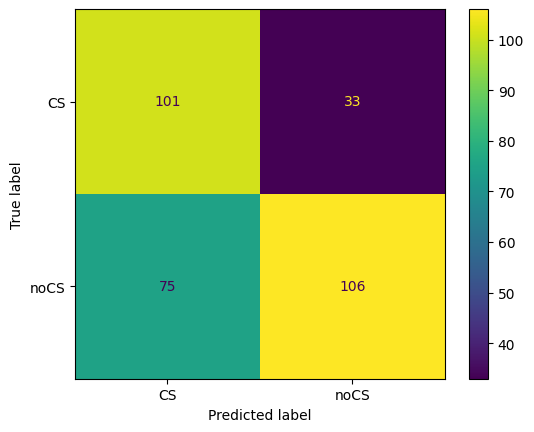

In [144]:
base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_split=10, class_weight="balanced")

# Rebuild the bagging classifier with the tuned DecisionTreeClassifier
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=200, random_state=42)

# Evaluate the model
evaluate_model(bagging_model)

Balanced accuracy on test: 0.6602828399439268
Balanced accuracy on train: 0.838262561730095
Classification Report:
              precision    recall  f1-score   support

          CS       0.57      0.72      0.64       134
        noCS       0.74      0.60      0.66       181

    accuracy                           0.65       315
   macro avg       0.66      0.66      0.65       315
weighted avg       0.67      0.65      0.65       315

Confusion matrix:


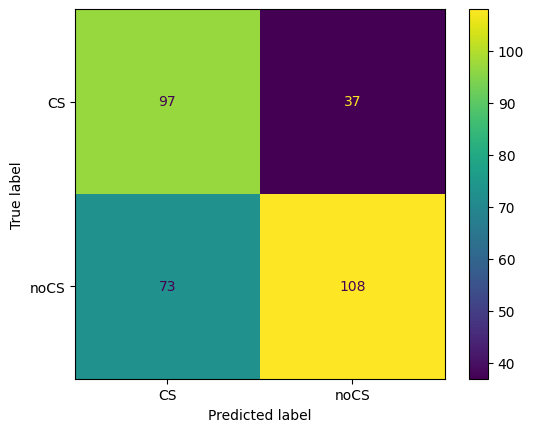

In [145]:
bagging_model = BaggingClassifier(base_estimator=base_estimator, 
                                  n_estimators=100, 
                                  max_samples=0.8,   # Train each base estimator on 80% of the samples-->adds randomness and can improve generalization
                                  max_features=0.8,  # Use only 80% of the features--> diversity in the base estimators, reducing overfitting
                                  random_state=42)
evaluate_model(bagging_model)

Balanced accuracy on test: 0.6576647150985404
Balanced accuracy on train: 0.8198949899946761
Classification Report:
              precision    recall  f1-score   support

          CS       0.56      0.75      0.64       134
        noCS       0.75      0.57      0.65       181

    accuracy                           0.64       315
   macro avg       0.66      0.66      0.64       315
weighted avg       0.67      0.64      0.64       315

Confusion matrix:


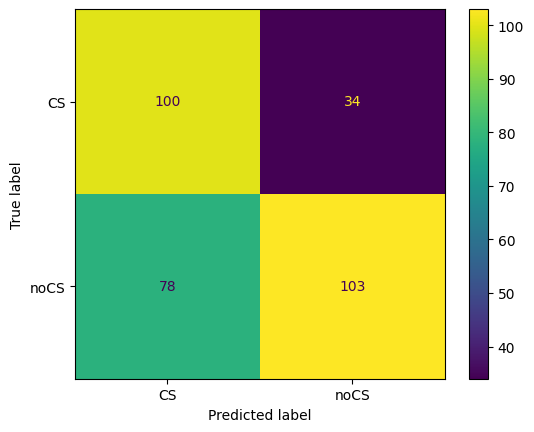

In [146]:
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=500, random_state=42)
evaluate_model(bagging_model)
